In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes
from pygimli.physics.ert import createERTData, ERTModelling
from pygimli.frameworks import MeshMethodManager

(<AxesSubplot:>, None)

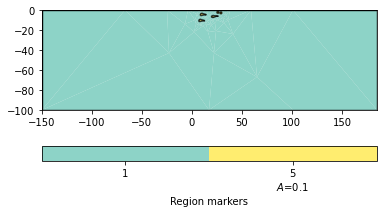

In [2]:
world = mt.createWorld(start=[-150, -100], end=[184.5, 0])
poly = mt.createPolygon([(19.5,-6.5), (21,-5.2), (23,-5.5), (24,-5.5),
                         (26.5,-6), (23.5,-6.2), (22,-7)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

# poly = mt.createPolygon([(19.5,-8.5), (21,-7.2), (23,-7.5), (24,-7.5),
#                          (26.5,-8), (23.5,-8.2), (22,-9)], isClosed=True,
#                          addNodes=3, interpolate='spline', marker=5)
poly1 = mt.createPolygon([(8.5,-5), (9.5,-3), (11.5,-3.5), (13.5,-4),
                         (14.5,-4.5), (12.5,-4.5), (10.5,-5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)
poly2 = mt.createPolygon([(7,-11), (8,-9), (10,-9.5), (12,-10),
                         (13,-10.5), (11,-10.5), (9,-11)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)
circle = mt.createCircle(pos=[26, -2], radius=[1, 1], marker=5, area=0.1)
circle1 = mt.createCircle(pos=[29, -2.5], radius=[1, 1], marker=5, area=0.1)
# circle2 = mt.createCircle(pos=[27.75, -8], radius=[1, 1], marker=5, area=0.1)

world +=poly
world +=poly1
world +=poly2
world +=circle
world +=circle1
# world +=circle2
pg.show(world)

In [3]:
shmgeo = ert.createData(elecs=np.linspace(start=0, stop=34.5, num=24), schemeName='dd')

In [4]:
# shmslm= ert.createData(elecs=np.linspace(start=0, stop=34.5, num=24), schemeName='slm')
# shmslm.remove(8*(shmslm['n']-shmslm['m']) < (shmslm['m']-shmslm['a']))
# shmslm

In [5]:
# shmslm= pg.load('aashl.dat')
# shmslm.remove(8*(shmslm['n']-shmslm['m']) < (shmslm['m']-shmslm['a']))
# shmslm

In [6]:
# shmdd= pg.load('aadip_dipsurf.dat')
# shmdd.remove(8*(shmdd['b']-shmdd['a']) < (shmdd['m']-shmdd['a']))
# shmdd

In [8]:
# shmdd= ert.createData(elecs=np.linspace(start=0, stop=34.5, num=24), schemeName='dd')
# shmdd.remove(8*(shmdd['b']-shmdd['a']) < (shmdd['m']-shmdd['a']))
# shmdd

Data: Sensors: 24 data: 126, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [9]:
# shm=shmdd
# shm.add(shmslm)
# shm

In [10]:
shm= pg.load('shmslm.dat')
shm.add(shmdd)
shm

Data: Sensors: 24 data: 238, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [ ]:
# shmslm,shmdd

In [7]:
shm=pg.load("aa4sim.dat")
# shm.add(pg.load("aa6.dat"))
# shm.add(pg.load("aa13.dat"))
# shm.add(pg.load("aa15.dat"))
# shm.add(pg.load("aa8.dat"))
# shm.add(pg.load("aa9.dat")) 
# shm.add(pg.load("aa4sim.dat")) 
# shm.add(pg.load("aa4enterres.dat")) 
shm

Data: Sensors: 32 data: 116, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [8]:
# # shm = pg.load("aashl.dat")
# shmslm.remove(8*(shmslm['n']-shmslm['m']) < (shmslm['m']-shmslm['a']))
# shmslm

In [9]:
# shm.save('aashm1.dat')

In [10]:
# shmdd.remove(8*(shmdd['b']-shmdd['a']) < (shmdd['m']-shmdd['a']))
# shmdd

In [11]:
for s in shm.sensors():
    world.createNode(s, marker=-99)
    world.createNode(s - [0, 0.01])

world #30 nodes + 18 * 2 (electrodes) = 66 nodes

Mesh: Nodes: 176 Cells: 0 Boundaries: 112

(<AxesSubplot:>, None)

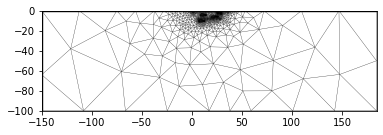

In [12]:
mesh=mt.createMesh(world, quality=34)
pg.show(mesh)

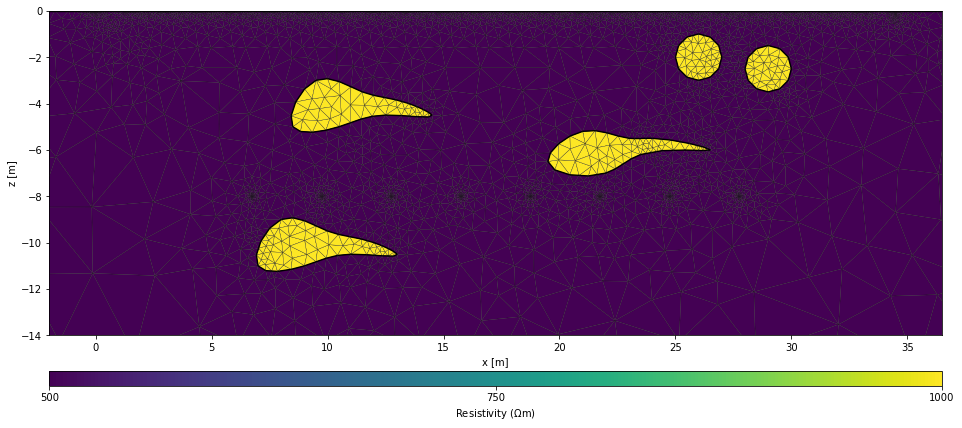

In [13]:
rhomap = [ [1, 500],    #couverture
           [5, 1000]] #polluant
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(mesh, data=rhomap, label=pg.unit('res'), ax=ax,showMesh=True,logScale=False, nLevs=3, xlabel='x [m]', ylabel='z [m]')
ax.set_xlim(-2,36.5)
ax.set_ylim(-14,0)
plt.savefig('modelepollluant.pdf')

## Simulation

(<AxesSubplot:>, None)

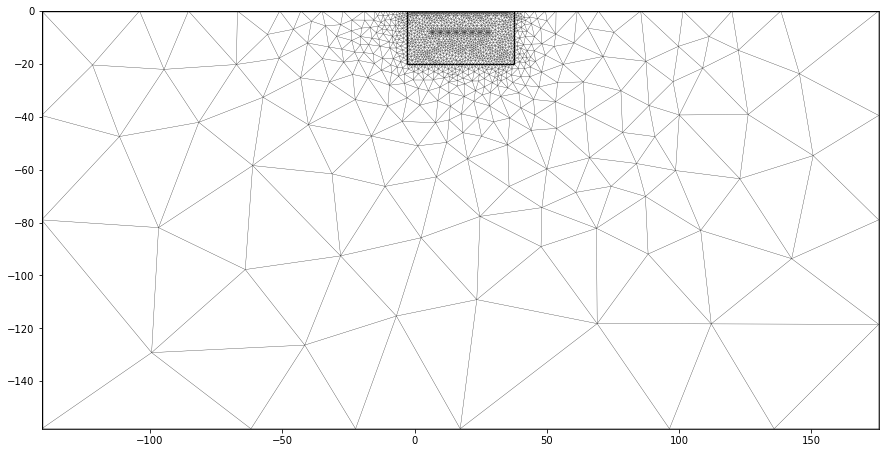

In [14]:
geo=pg.meshtools.createParaMeshPLC(shmgeo,paraMaxCellSize=1, paraDepth=20)
for p in shm.sensors():
    geo.createNode(p)
    geo.createNode(p - [0, 0.1])
mesh_invplc = pg.meshtools.createMesh(geo, quality=34)
fig, ax = plt.subplots(figsize=(15, 8))
pg.show(mesh_invplc, ax=ax, markers=False)
# ax.set_xlim(-5,111.5)
# ax.set_ylim(-50,0)

In [15]:
noiseAbs = 5e-5
noiseLevel = 0.03

In [16]:
hom = ert.simulate(mesh_invplc, res=1.0, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)

hom.save('homogeneous.ohm', 'a b m n u')

1

In [17]:
data = ert.simulate(mesh, res=rhomap, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)
#pg.show(mesh, notebook=True)

In [18]:
data['err'] = ert.estimateError(data, absoluteUError=noiseAbs, relativeError=noiseLevel) #50microV et 3%

In [19]:
noise = data('u')*data('err') * pg.randn(data.size(), seed=1337)

In [20]:
noise

116 [-0.0009188092088483201,...,0.003575593871447509]

In [21]:
data.set('u', data('u') + noise)

In [22]:
data.set('k', 1.0/ (hom('u') / hom('i')))
data.set('rhoa', data('k') * data('u') / data('i'))
# data['err'] = ert.estimateError(data, absoluteUError=5e-5, relativeError=0.03) #50microV et 3%

data.save('simulated.dat', 'a b m n rhoa k u i err')

# np.testing.assert_approx_equal(het('rhoa')[0], 9.5, 1)

1

In [23]:
data['err']

116 [0.03119366395266776,...,0.030060390485278993]

In [24]:
pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

14/06/22 - 11:35:18 - pyGIMLi - INFO - 0.3254978066886053 7604.198481979683
14/06/22 - 11:35:18 - pyGIMLi - INFO - Simulated data Data: Sensors: 32 data: 116, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']
14/06/22 - 11:35:18 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
14/06/22 - 11:35:18 - pyGIMLi - INFO - Simulated rhoa (min/max) -2991.6616577724317 3104.545611284232
14/06/22 - 11:35:18 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0030898530087837 3.8304571818978244


In [25]:
a=np.count_nonzero(data['rhoa'])
a

116

In [26]:
pg.info('rhoa<0', 100*(np.count_nonzero(data['rhoa']<0)/a))
pg.info('err>5', 100*(np.count_nonzero(data['err']>0.05)/a))
pg.info('k>5000', 100*(np.count_nonzero(abs(data['k'])>5000)/a))

14/06/22 - 11:35:20 - pyGIMLi - INFO - rhoa<0 4.310344827586207
14/06/22 - 11:35:20 - pyGIMLi - INFO - err>5 0.0
14/06/22 - 11:35:20 - pyGIMLi - INFO - k>5000 0.0


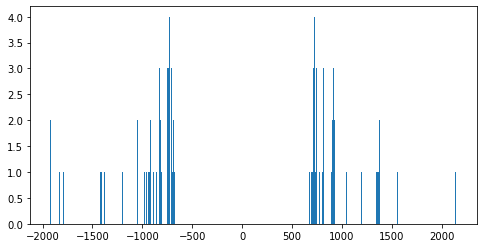

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(data['k'], bins=600);

In [34]:
data.remove(data['rhoa'] < 200)
data.remove(data['rhoa'] > 800)
data.remove(data['err'] > 0.05)
data.remove(abs(data['k'])>5000)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa'])) #si rhoa <0
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)


data.save('simulated.dat')
data

06/06/22 - 23:34:28 - pyGIMLi - INFO - Filtered rhoa (min/max) 204.44532128559436 746.7490902841953
06/06/22 - 23:34:28 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0000878761902214 3.0422084439851256


Data: Sensors: 32 data: 2219, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

In [35]:
pg.info('filtré', (100*(a-np.count_nonzero(data['rhoa']))/a))

06/06/22 - 23:34:31 - pyGIMLi - INFO - filtré 6.489675516224189


In [31]:
b = int(2 * ((np.percentile(data['rhoa'], 75)-np.percentile(data['rhoa'], 25))/np.cbrt(len(data['rhoa']))))
b

107

Data: Sensors: 32 data: 110, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

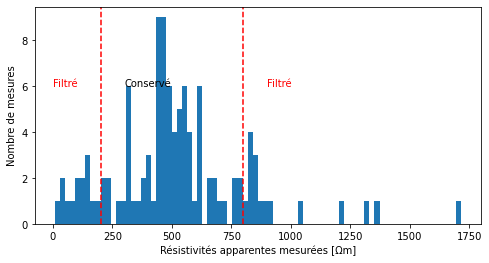

In [41]:
# data.remove(data['rhoa'] > 60)
# data.remove(data['rhoa'] < 20)
data.remove(data['k'] > 5000)
data.remove(data['rhoa']>3000)
data.remove(data['err'] > 0.05)
fig, ax = plt.subplots(figsize=(8,4))
plt.axvline(x=200,color='red',linestyle='--')
plt.axvline(x=800,color='red',linestyle='--')
ax.annotate('Filtré', (0, 6), color='red')
ax.annotate('Filtré', (900, 6), color='red')
ax.annotate('Conservé', (300, 6), color='black')
ax.hist(data['rhoa'], bins=80)
ax.set_xlabel('Résistivités apparentes mesurées [Ωm]') 
ax.set_ylabel('Nombre de mesures')
# plt.savefig('TOF/hist4sim.pdf', bbox_inches='tight', pad_inches=0.05)
data

## Inversion

In [42]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}

In [ ]:
# median=np.median(data('rhoa'))
# mA0=median*20
# mB0=median*0.05
# # experience = {'inverted_model': median, 'mA0': mA0, 'mB0': mB0}
# experience = {'mA0': mA0, 'mB0': mB0}
# mA0, mB0

In [ ]:
# mgr = ert.ERTManager('simulated.dat')
# for name,  startmodel in experience.items():
#     inv = mgr.invert(data = data, mesh=mesh_invplc, lam=100, verbose=True, startModel=startmodel)
#     mgr.saveResult(name)

In [52]:
mgr = ert.ERTManager('simulated.dat')
inv = mgr.invert(data = data, mesh=mesh_invplc, lam=10, verbose=True, robustData=False, blockyModel=True)

06/06/22 - 23:39:49 - pyGIMLi - INFO - Found 2 regions.
06/06/22 - 23:39:49 - pyGIMLi - INFO - Region with smallest marker (1) set to background
06/06/22 - 23:39:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/22 - 23:39:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/22 - 23:39:49 - pyGIMLi - INFO - Use median(data values)=526.1354902195075
06/06/22 - 23:39:49 - pyGIMLi - INFO - Created startmodel from forward operator: 2812 [526.1354902195075,...,526.1354902195075]
06/06/22 - 23:39:49 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000019734A1D4F0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001973492D400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000019734A1D400>
min/max (data): 204/747
min/max (error): 3%/3.04%
min/max (start model): 526/526
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.05 (dPhi = 32.81%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 0.91 (dPhi = 12.71%) lam: 10.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################


In [53]:
# loadmesh = pg.load('ENTjust/ERTManager/resistivity-pd.bms')
# modelP = pg.load('ENTjust/ERTManager/resistivity.vector')

In [54]:
modelP = mgr.paraModel(inv)  # do the mapping
loadmesh = mgr.paraDomain

In [55]:
# mgr.saveResult()

(-14.0, 0.0)

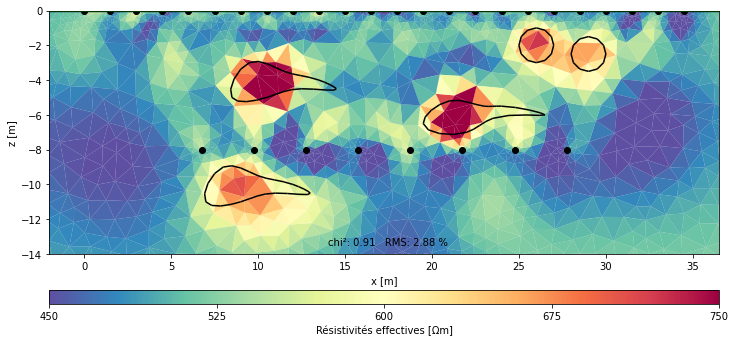

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (14, -13.5))
pg.show(mgr.paraDomain, modelP, ax=ax, cMap='Spectral_r', logScale=False,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin=450, cMax=750)
pg.viewer.mpl.drawMeshBoundaries(ax, world, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='k')  #data.remove(data['rhoa'] < 20) data.remove(data['err'] > 0.02) coverage=mgr.coverage(),
ax.set_xlim(-2,36.5)
ax.set_ylim(-14,0)
# plt.savefig('tof/4sim.pdf')

In [ ]:
# mgr.showResult()
# plt.savefig('Tof/Inversion 4sim lam30vierge.pdf')

In [ ]:
modelP = mgr.paraModel(inv)  # do the mapping
fig, ax = plt.subplots(figsize=(30, 14))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mgr.paraDomain, modelP, ax=ax, cMap='Spectral_r',
        logScale=False,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, world, hideMesh=True, fitView=False, 
                                 linewidth=0.1)  #data.remove(data['rhoa'] < 20) data.remove(data['err'] > 0.02)
plt.savefig('Inversion 6 draw L2 lam50.pdf')

In [ ]:
print( f'chi²: {round(mgr.inv.chi2(),2)}')
print( f'RMS: {round(mgr.inv.relrms(),2)}')

In [ ]:
mgr.showFit()
plt.savefig('showFit tout L2.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
mgr.showMisfit(ax=ax, label='Relative misfit (%)')
plt.savefig('misfit dd.pdf')

#### Surface

In [ ]:
pos = {i+1 : np.array(shmgeo.sensorPosition(i)) for i in range(shmgeo.sensorCount())}
R = []
mAxz = pg.load('mA0/ERTManager/resistivity.vector') #surf
mBxz = pg.load('mB0/ERTManager/resistivity.vector') #surf
mesh_doi = pg.load('mA0/ERTManager/resistivity-pd.bms') #surf

In [ ]:
mesh_doi

In [ ]:
R = (mAxz - mBxz)/(mA0-mB0)

In [ ]:
plt.hist(R, bins=200);

In [ ]:
R

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, abs(R), ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index', cMin=0, cMax=0.2)
pg.viewer.mpl.drawMeshBoundaries(ax, world, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='k')
# ax.set_ylim(-30,0)
# plt.savefig('tof04_06/scale.pdf')